# Project Title: Predicting Song Popularity on Spotify using Supervised Learning



# Problem Definition
Objective:
The goal of this project is to develop a classification model that predicts whether a song will be a “hit” (popular) or “non-hit” based on its musical and acoustic characteristics available on Spotify.

Formally, given a set of audio features (e.g., danceability, energy, valence, loudness, tempo), the model should learn to classify songs into popularity categories such as:

1 (Popular / Hit)

0 (Unpopular / Non-hit)

This is a supervised binary classification problem.


# Data Collection and Provenance

Dataset: Ultimate Spotify Tracks Dataset

Repository: [Kaggle Dataset – Ultimate Spotify Tracks DB](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db)

Author: Zaheen Hamidani (Kaggle Contributor)

Data Format: `CSV`

**Collection Method:**

The dataset aggregates data using the Spotify Web API, which provides audio features for over 232,000 songs. These tracks include various genres and time periods, collected by querying the Spotify API via the spotipy Python client.
Each track is associated with metadata (track ID, artist, album, year) and quantitative audio features computed by Spotify’s proprietary signal analysis algorithms.

Data Provenance and Legality:

The dataset is publicly available under Kaggle’s usage terms for educational purposes.

Data is aggregated from the Spotify Developer API, which explicitly allows non-commercial academic usage.

No personally identifiable information (PII) or copyrighted material is stored — only song-level metadata.

The dataset includes continuous and categorical variables suitable for diverse EDA and model experiments (e.g., logistic regression, random forest, gradient boosting). Predicting song popularity aligns with real-world music industry applications such as playlist curation, marketing optimization, and trend forecasting.

# Dataset Overview
| **Category**            | **Details**                                                                          |
| ----------------------- | ------------------------------------------------------------------------------------ |
| **Number of Instances** | ~232,000 tracks                                                                      |
| **Number of Features**  | ~18                                                                                  |
| **Target Variable**     | `popularity` (converted into categorical hit/non-hit)                                |
| **Data Type**           | Tabular (numeric, categorical, text)                                                 |
| **Format**              | CSV                                                                                  |
| **Missing Values**      | Some columns (e.g., `key`, `mode`, `genre`) may have missing or inconsistent entries |
| **Duplicates**          | Possible duplicate songs across albums or re-releases                                |


# Features (Factors)
Key audio features provided by Spotify’s API:
| **Feature**        | **Description**                       | **Type**      |
| ------------------ | ------------------------------------- | ------------- |
| `danceability`     | How suitable a track is for dancing   | Numeric (0–1) |
| `energy`           | Intensity and activity measure        | Numeric (0–1) |
| `loudness`         | Overall loudness in dB                | Numeric       |
| `speechiness`      | Presence of spoken words              | Numeric (0–1) |
| `acousticness`     | Confidence that the track is acoustic | Numeric (0–1) |
| `instrumentalness` | Likelihood the track is instrumental  | Numeric (0–1) |
| `liveness`         | Probability track was performed live  | Numeric (0–1) |
| `valence`          | Positivity or “mood” of the track     | Numeric (0–1) |
| `tempo`            | Beats per minute (BPM)                | Numeric       |
| `duration_ms`      | Length of the track in milliseconds   | Numeric       |
| `genre`            | Genre classification                  | Categorical   |
| `artist_name`      | Performer                             | Text          |
| `track_name`       | Title                                 | Text          |
| `popularity`       | Spotify popularity index (0–100)      | Target        |


# Data Cleaning

In [163]:
# Standard Library Imports
import os
import warnings

# Silence unnecessary warnings
warnings.filterwarnings("ignore")

# Core Data Science Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: Preprocessing & Model Selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Scikit-learn: Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn: Metrics
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve
)
# Imbalanced-learn (Sampling + Pipeline)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Hyperparameter Distributions (for RandomizedSearchCV)
from scipy.stats import randint, uniform

# XGBoost
from xgboost import XGBClassifier

In [164]:
# Configurations
DATA_PATH = "/content/sample_data/SpotifyFeatures.csv"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [165]:
# Load data
df = pd.read_csv(DATA_PATH)
df.head(3)


genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV    0.000000      0.611000      0.389000   
1  0BjC1NfoEOOusryehmNudP    1.000000      0.246000      0.590000   
2  0CoSDzoNIKCRs124s9uTVy    3.000000      0.952000      0.663000   

    duration_ms   energy  instrumentalness key  liveness   loudness   mode  \
0  99373.000000 0.910000          0.000000  C#  0.346000  -1.828000  Major   
1 137373.000000 0.737000          0.000000  F#  0.151000  -5.559000  Minor   
2 170267.000000 0.131000          0.000000   C  0.103000 -13.879000  Minor   

   speechiness      tempo time_signature  valence  
0     0.052500 166.969000            4/4 0.814000  
1     0.086800 174.003000            4/4 0.816000  
2     0.036200  99.488000            5/4 0.368000

In [166]:
print(df.dtypes)


genre                object
artist_name          object
track_name           object
track_id             object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo               float64
time_signature       object
valence             float64
dtype: object


In [167]:
df.describe()

popularity  acousticness  danceability    duration_ms       energy  \
count 65881.000000  65881.000000  65881.000000   65881.000000 65881.000000   
mean     41.411682      0.286484      0.554219  238965.321823     0.625042   
std      15.895854      0.322817      0.158393   98901.972930     0.246112   
min       0.000000      0.000000      0.059200   17213.000000     0.000909   
25%      31.000000      0.016500      0.453000  192459.000000     0.452000   
50%      43.000000      0.134000      0.564000  226467.000000     0.659000   
75%      53.000000      0.514000      0.667000  268800.000000     0.833000   
max     100.000000      0.996000      0.987000 4830606.000000     0.999000   

       instrumentalness     liveness     loudness  speechiness        tempo  \
count      65881.000000 65881.000000 65881.000000 65881.000000 65881.000000   
mean           0.135050     0.197721    -8.146080     0.076725   121.440120   
std            0.279726     0.166528     4.574027     0.084467    29.719044   
min            0.000000     0.009670   -43.025000     0.022200    32.080000   
25%            0.000000     0.097200   -10.246000     0.034400    97.988000   
50%            0.000164     0.129000    -7.080000     0.045800   120.045000   
75%            0.047300     0.251000    -4.990000     0.077400   140.100000   
max            0.997000     1.000000     3.744000     0.965000   242.903000   

           valence  
count 65881.000000  
mean      0.464383  
std       0.243892  
min       0.000000  
25%       0.270000  
50%       0.452000  
75%       0.651000  
max       1.000000

In [168]:
df.shape

(65882, 18)

In [169]:
# check for NaN values
pd.isnull(df).sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          1
acousticness        1
danceability        1
duration_ms         1
energy              1
instrumentalness    1
key                 1
liveness            1
loudness            1
mode                1
speechiness         1
tempo               1
time_signature      1
valence             1
dtype: int64

In [170]:
# remove NaN
df_clean = df.dropna()
df = df_clean
pd.isnull(df).sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [171]:
df.shape

(65881, 18)



# Outlier
During the data exploration phase, we identified a small number of tracks that stood out as clear outliers—songs either unusually brief (under 20 seconds) or exceptionally long (over 10 minutes). In total, 2,181 such tracks were detected and subsequently removed to maintain analytical consistency. After this refinement, the dataset retained a solid 230,543 tracks, providing a well-balanced foundation for further analysis. In essence, this step was akin to curating a playlist—removing the fleeting intros and marathon live performances so that the dataset reflects the true essence of typical musical tracks.


In [172]:
df_outliers_duration = df[
    (df['duration_ms'] < 20000) | (df['duration_ms'] > 600000)
]
print(len(df_outliers_duration))
# we have 2181 songs that too short (less than 20s) or too long (greater than 10
# miniutes). We can remove these outliers
df = df[
    (df['duration_ms'] >= 20000) &
    (df['duration_ms'] <= 600000)
]
print(len(df)) # We still have 230543 tracks to work with. NICE!

314
65567


Rare genres (<1%):
['A Capella']


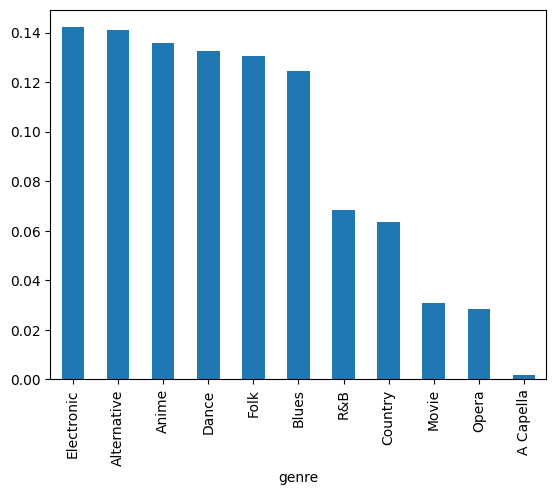

In [173]:
df['genre'].value_counts(normalize=True).plot(kind='bar')
genre_freq = df['genre'].value_counts(normalize=True)

# Identify genres representing less than 1% of the data
rare_genres = genre_freq[genre_freq < 0.01].index

print("Rare genres (<1%):")
print(list(rare_genres))

# Remove them
df= df[~df['genre'].isin(rare_genres)]

Seems like A Capella is a very rare genera. So we should remove it. *Note: There's "Children's Music" and "Children’s Music" with different apostrophes. Quick Google search said that they are indeed two different genra. So we will keep them as it is.*

In [174]:
# check for duplicate values
dupe_keys = ['track_name', 'artist_name', 'duration_ms', 'genre']
print(f"Before cleaning: {df.shape}")
# Identify duplicates
df_deduped = df.drop_duplicates(subset=dupe_keys, keep='first')
df = df_deduped
print(f"After cleaning: {df.shape}")

Before cleaning: (65448, 18)
After cleaning: (65448, 18)


Great!!! we have no duplicate rows with the same values for `"track_name"`, `"artist_name"`, `"duration_ms"` and `"genre"`. We needed to include `"genre"` since a song can belong to multiple genres.

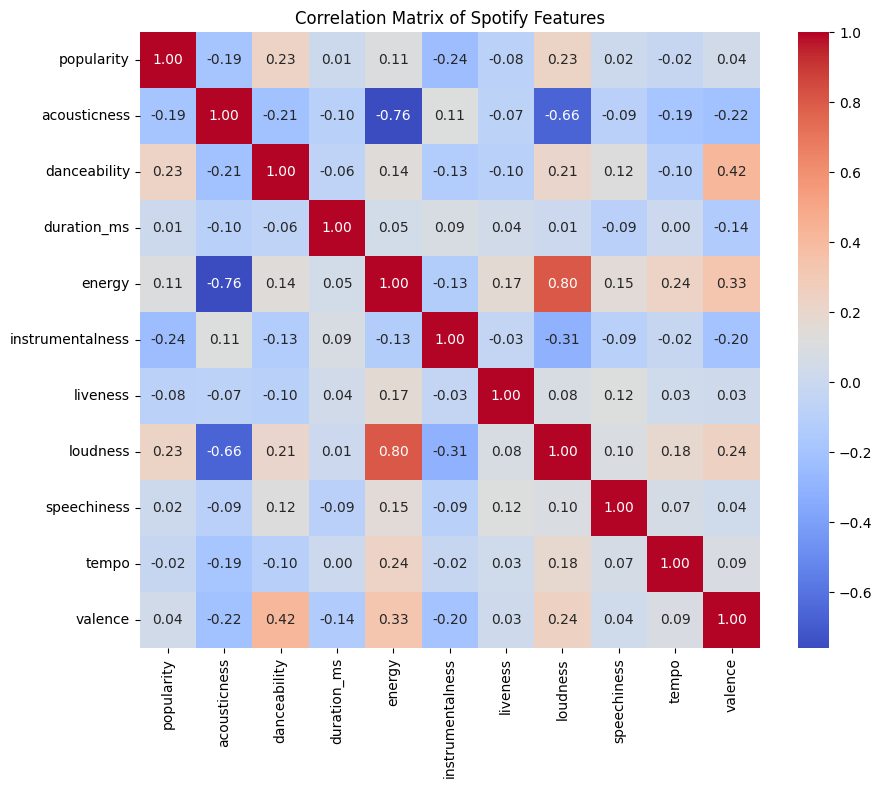

In [175]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Spotify Features')
plt.show()

energy & loudness (0.80) - VERY highly correlated.
Looks like we can remove `'loudness'` since `'energy'` is a more common indicator for `'popularity'` and `'energy'` and `'loudness'` are highly correlated which means energetic tracks tend to be louder. We can safely remove `'loudness'` without significant information loss.


In [176]:
df.drop(columns=['loudness'], inplace=True)

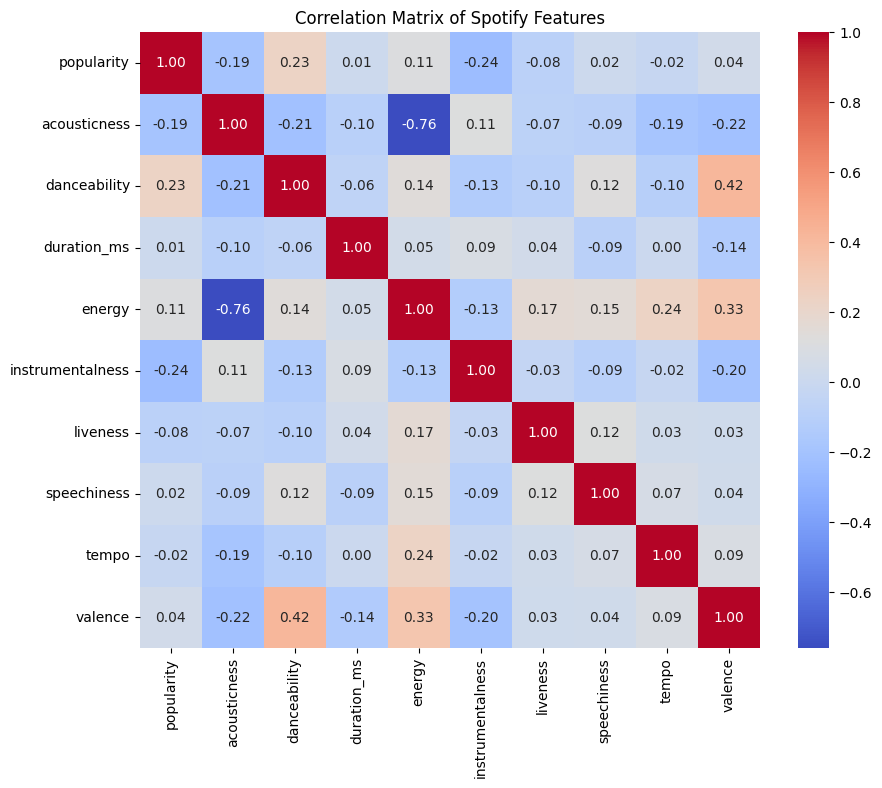

In [177]:
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Spotify Features')
plt.show()

After removing the correlated feature, our most relevant features in the order of magnitude:


1.   instrumentalness (-0.24)
2.   dancibility (+0.23)
3.   acousticness (-0.19)
4.   energy (+0.11)



# Feature Engineering

We'll convert the popularity score into a binary classification problem. Songs with a popularity score of 51 or higher will be labeled as "popular" (encoded as 1), since this threshold represents the top 70th percentile of all tracks. Songs scoring below 51 will be classified as "not popular" (encoded as 0).

70th percentile value: 51.0


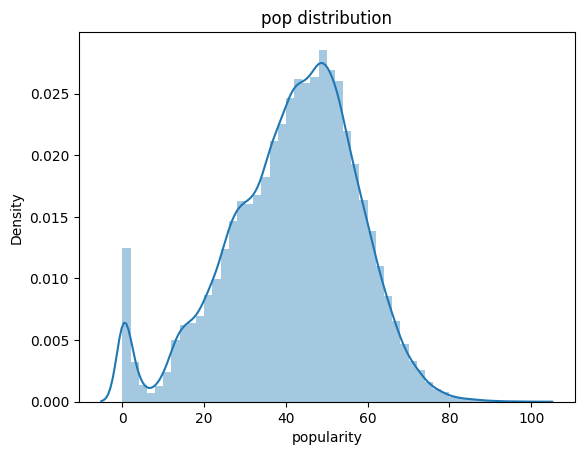

In [178]:
sns.distplot(df['popularity']).set_title('pop distribution')
percentile_70 = df['popularity'].quantile(0.70)
print(f"70th percentile value: {percentile_70}")

In [179]:
df.loc[df['popularity']<51, 'popularity']=0
df.loc[df['popularity']>=51, 'popularity']=1
print(df['popularity'].value_counts())

popularity
0.000000    45524
1.000000    19924
Name: count, dtype: int64


Great! We have 207264 "unpopular" and 25460 "popular" songs

Key Encoding: Musical keys are represented by 12 distinct letter names (A, A#, B, C, C#, D, D#, E, F, F#, G, G#), regardless of whether they're major or minor. To convert these text labels into numerical values that machine learning models can process, we'll assign each unique key an integer from 0 to 11. For example, A maps to 0, A# maps to 1, continuing sequentially until B maps to 11.

In [180]:
enc = OneHotEncoder(sparse_output=True)
encoded = enc.fit_transform(df[['key']])

In [181]:

df_encoded = pd.DataFrame(
    encoded.toarray(),
    columns=enc.get_feature_names_out(['key'])
)
df_encoded.head(20)

key_A   key_A#    key_B    key_C   key_C#    key_D   key_D#    key_E  \
0  0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000   
1  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
2  0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000   
3  0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000   
4  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
5  0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000   
6  0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000   
7  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
8  0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000   
9  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
10 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000   
11 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000   
12 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
13 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000   
14 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000   
15 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000   
16 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000   
17 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000   
18 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000   
19 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000   

      key_F   key_F#    key_G   key_G#  
0  0.000000 0.000000 0.000000 0.000000  
1  0.000000 1.000000 0.000000 0.000000  
2  0.000000 0.000000 0.000000 0.000000  
3  0.000000 0.000000 0.000000 0.000000  
4  1.000000 0.000000 0.000000 0.000000  
5  0.000000 0.000000 0.000000 0.000000  
6  0.000000 0.000000 0.000000 0.000000  
7  0.000000 1.000000 0.000000 0.000000  
8  0.000000 0.000000 0.000000 0.000000  
9  0.000000 0.000000 1.000000 0.000000  
10 0.000000 0.000000 0.000000 0.000000  
11 0.000000 0.000000 0.000000 0.000000  
12 0.000000 1.000000 0.000000 0.000000  
13 0.000000 0.000000 0.000000 0.000000  
14 0.000000 0.000000 1.000000 0.000000  
15 0.000000 0.000000 0.000000 0.000000  
16 0.000000 0.000000 0.000000 0.000000  
17 0.000000 0.000000 0.000000 0.000000  
18 0.000000 0.000000 0.000000 0.000000  
19 0.000000 0.000000 0.000000 0.000000

In [182]:
df = pd.concat(
    [df.reset_index(drop=True), df_encoded],
    axis=1
).drop(columns=['key'])
df.head(3)

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV    0.000000      0.611000      0.389000   
1  0BjC1NfoEOOusryehmNudP    0.000000      0.246000      0.590000   
2  0CoSDzoNIKCRs124s9uTVy    0.000000      0.952000      0.663000   

    duration_ms   energy  instrumentalness  ...    key_B    key_C   key_C#  \
0  99373.000000 0.910000          0.000000  ... 0.000000 0.000000 1.000000   
1 137373.000000 0.737000          0.000000  ... 0.000000 0.000000 0.000000   
2 170267.000000 0.131000          0.000000  ... 0.000000 1.000000 0.000000   

     key_D   key_D#    key_E    key_F   key_F#    key_G   key_G#  
0 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000  
1 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000  
2 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000  

[3 rows x 28 columns]

Next we will assign major = 1 and minor = 0

In [183]:
df.loc[df['mode'] == 'Major', 'mode'] = 1
df.loc[df['mode'] == 'Minor', 'mode'] = 0
df.sample(3)

genre   artist_name                  track_name  \
18521       Dance    Jhene Aiko                      Maniac   
36904  Electronic  Flying Lotus        Descent Into Madness   
51198       Blues        Clutch  Our Lady of Electric Light   

                     track_id  popularity  acousticness  danceability  \
18521  1i0lSglyW6FKjGcGyyp8Cj    1.000000      0.151000      0.432000   
36904  7KjUFMLiCdalMtGiAfuScC    0.000000      0.539000      0.453000   
51198  1KxWLXq2XHgdKf70rUF3M1    0.000000      0.015700      0.496000   

        duration_ms   energy  instrumentalness  ...    key_B    key_C  \
18521 206973.000000 0.534000          0.000001  ... 0.000000 0.000000   
36904  87225.000000 0.437000          0.416000  ... 0.000000 0.000000   
51198 231940.000000 0.766000          0.000275  ... 0.000000 0.000000   

        key_C#    key_D   key_D#    key_E    key_F   key_F#    key_G   key_G#  
18521 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000 0.000000  
36904 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000  
51198 0.000000 1.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000  

[3 rows x 28 columns]

Now we will convert the time signature values from their original format (like "4/4", "3/4", etc.) into sequential numerical labels. Each unique time signature in the dataset gets assigned a distinct integer starting from 0.

In [184]:
unique_signatures = df['time_signature'].unique()

# Map each unique time signature to a number (0, 1, 2, etc.)
for index in range(len(unique_signatures)):
    df.loc[df['time_signature'] == unique_signatures[index], 'time_signature'] = index

df.sample(3)

genre     artist_name         track_name                track_id  \
7407       Country       Lee Brice  Four On The Floor  2HfWDtxI4xuSWQtlXUN7Z4   
59151          R&B  Sinead Harnett            Lessons  61gMPDC1BYxaTFu3af2IBK   
27502  Alternative         Chromeo       Count Me Out  6hRCKc2OwSZWNKnFnsVb9p   

       popularity  acousticness  danceability   duration_ms   energy  \
7407     0.000000      0.007300      0.748000 209947.000000 0.697000   
59151    1.000000      0.448000      0.545000 226449.000000 0.509000   
27502    0.000000      0.070500      0.875000 216587.000000 0.602000   

       instrumentalness  ...    key_B    key_C   key_C#    key_D   key_D#  \
7407           0.000000  ... 0.000000 0.000000 0.000000 0.000000 0.000000   
59151          0.000000  ... 0.000000 0.000000 0.000000 0.000000 0.000000   
27502          0.000000  ... 0.000000 1.000000 0.000000 0.000000 0.000000   

         key_E    key_F   key_F#    key_G   key_G#  
7407  0.000000 0.000000 0.000000 0.000000 1.000000  
59151 1.000000 0.000000 0.000000 0.000000 0.000000  
27502 0.000000 0.000000 0.000000 0.000000 0.000000  

[3 rows x 28 columns]

We are removing `'track_id'` since it's just an unique identifier and `'duration_ms'` since it has no correlation to popularity we can remove `'artist_name'` and `'track_name'` since these two features have too many catagories. We can also remove` 'genre'` since we don't

In [185]:
print(df['genre'].nunique())
print(df['artist_name'].nunique())
print(df['track_name'].nunique())

irrelevant_features = ['track_id', 'duration_ms', 'artist_name', 'track_name',
                       'genre']

df_cleaned = df.drop(columns=irrelevant_features)
df = df_cleaned

10
6226
52885


In [186]:
df.columns

Index(['popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'valence', 'key_A', 'key_A#', 'key_B', 'key_C',
       'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G',
       'key_G#'],
      dtype='object')

In [187]:
# final feature selection
# We will drop 'key_G#' to prevent multicolinearity
df = df.drop(columns='key_G#')
important_features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G']

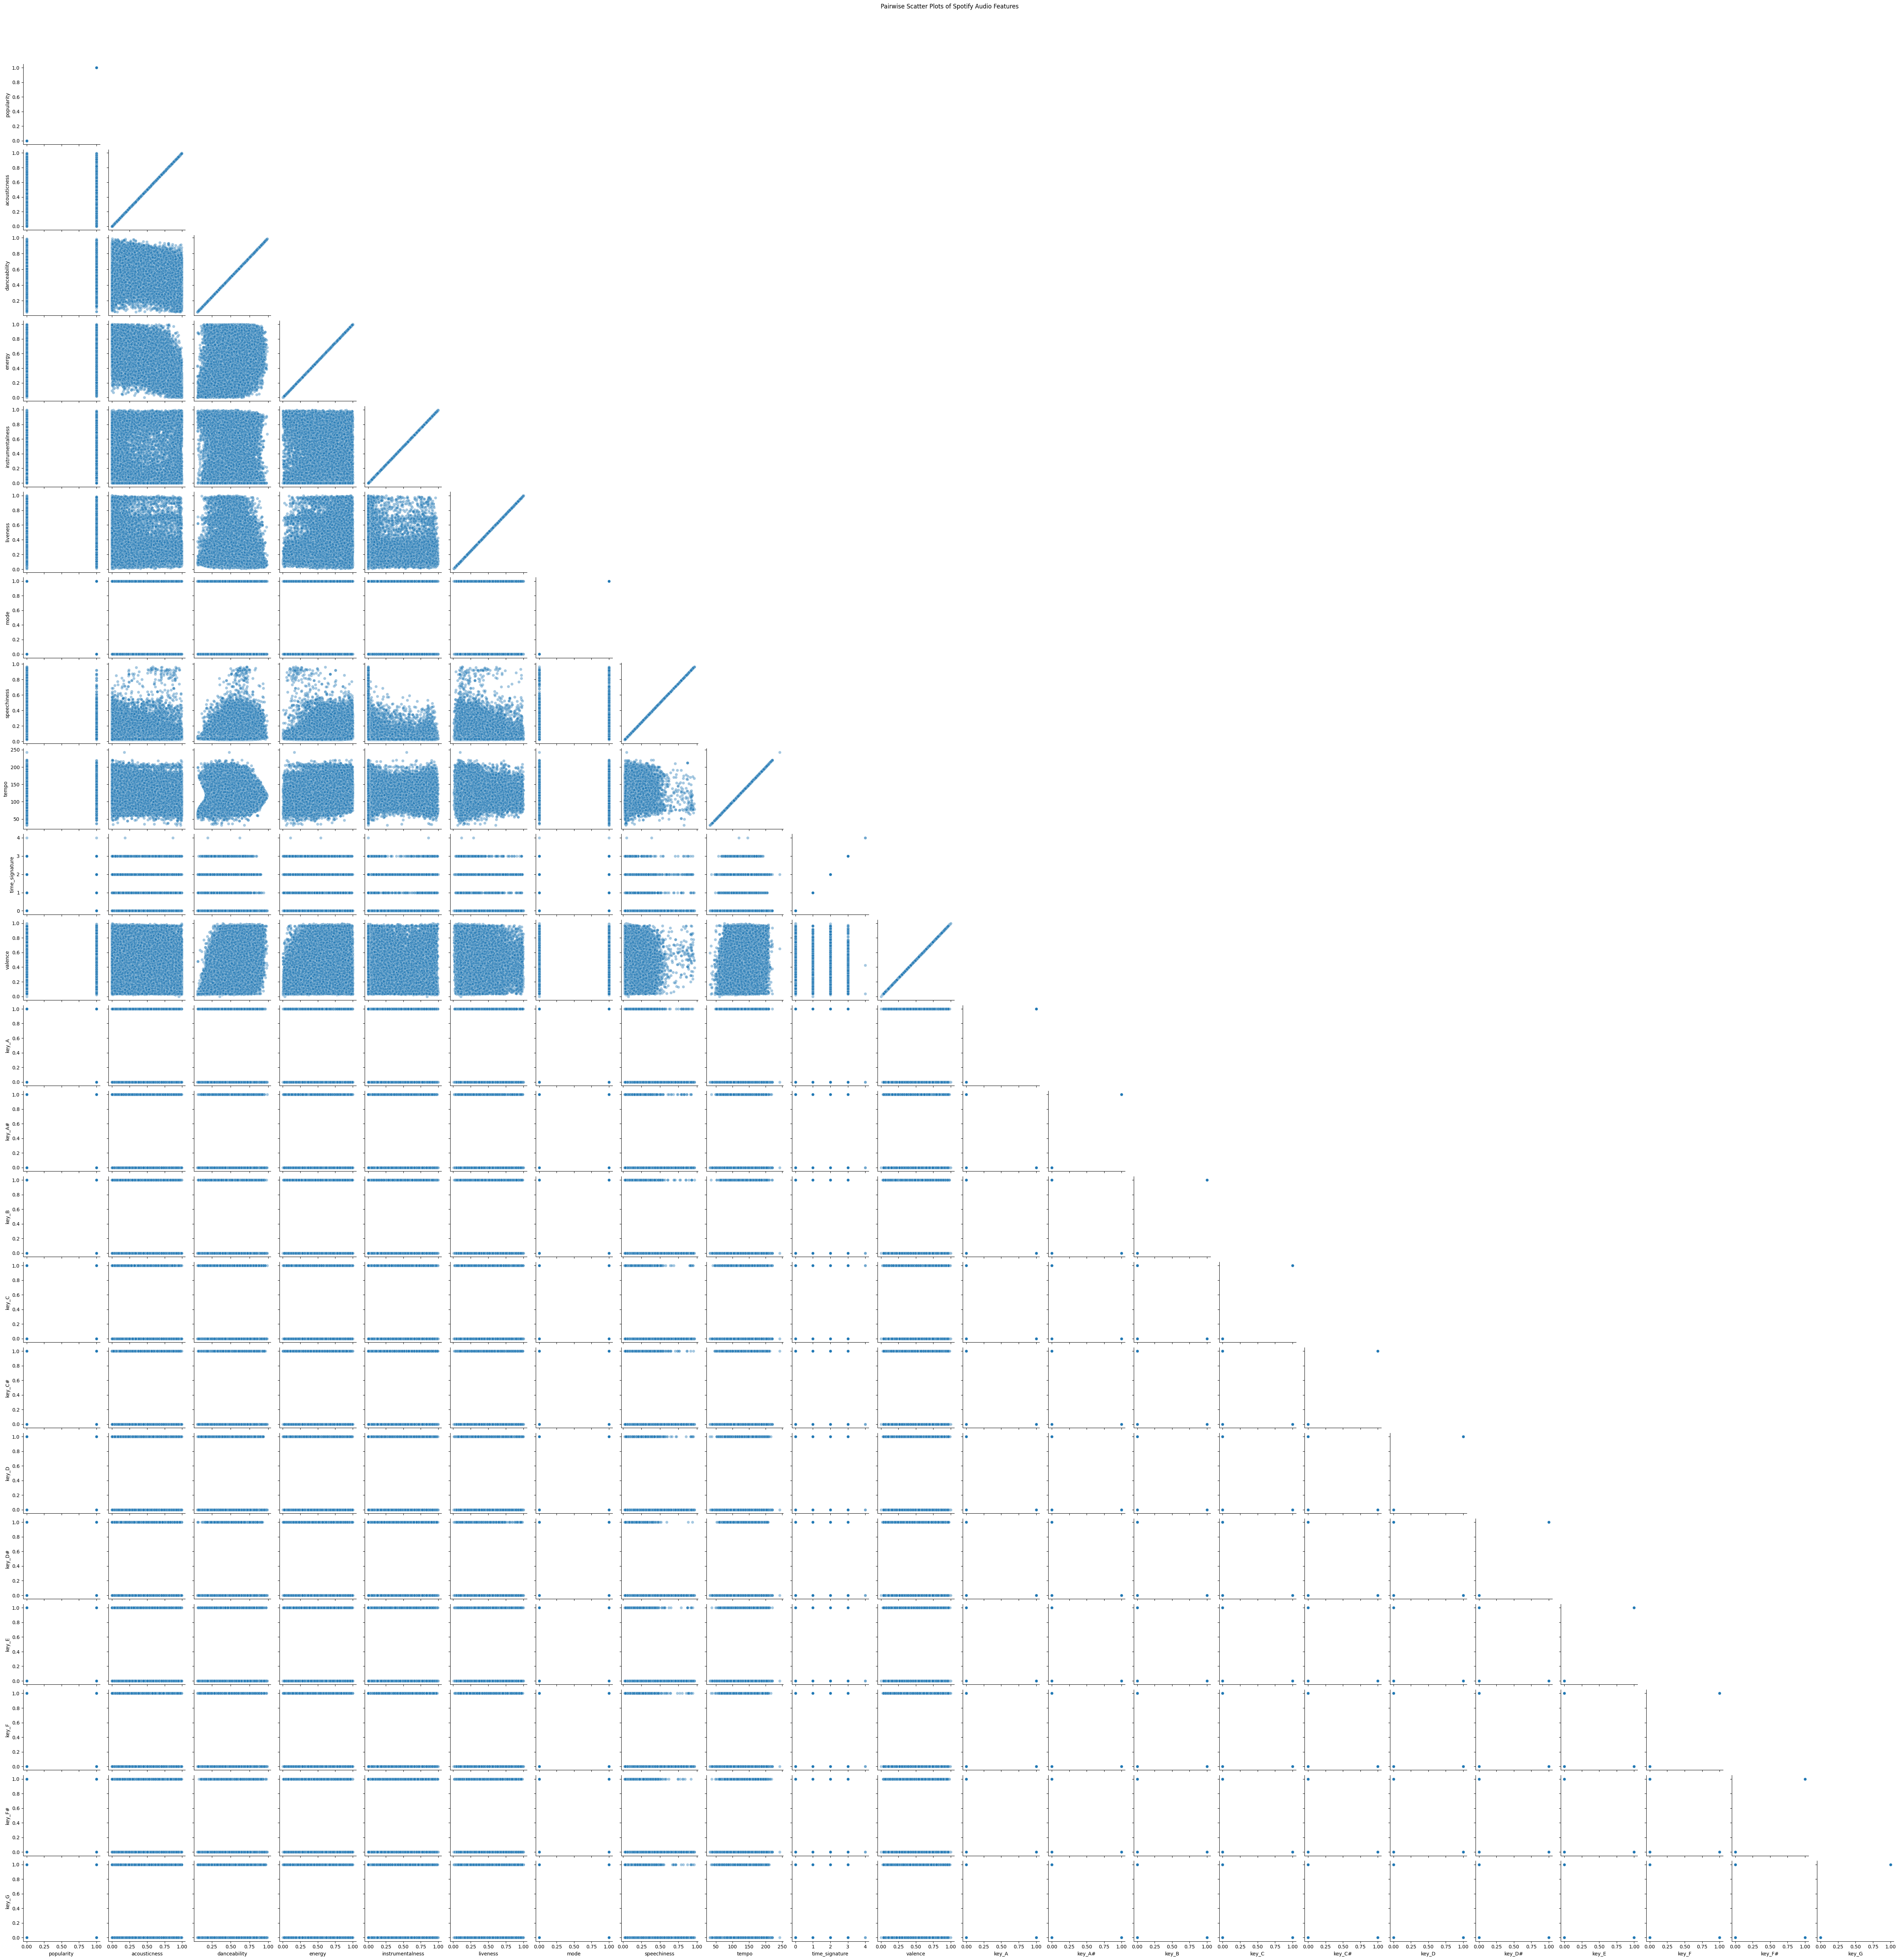

In [188]:
sns.pairplot(df[important_features], corner=True, diag_kind=None, plot_kws={'alpha':0.4})
plt.suptitle("Pairwise Scatter Plots of Spotify Audio Features", y=1.02)
plt.show()

# Summery:


In [189]:
# Shape and column names
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)

# First few rows
print("\nFirst 5 rows:")
print(df.head())

# Statistical summary
print("\nStatistical summary:")
print(df.describe())

Dataset shape: (65448, 22)

Columns: ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#', 'key_E', 'key_F', 'key_F#', 'key_G']

Data types:
popularity          float64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
liveness            float64
mode                 object
speechiness         float64
tempo               float64
time_signature       object
valence             float64
key_A               float64
key_A#              float64
key_B               float64
key_C               float64
key_C#              float64
key_D               float64
key_D#              float64
key_E               float64
key_F               float64
key_F#              float64
key_G               float64
dtype: object

First 5 rows:
   popularity  acousticness  danceability   energy  

The statistical summary indicates a clean, diverse, and representative dataset of over 230,000 songs.
Musical attributes show wide variation across acousticness, energy, and valence, enabling comprehensive modeling of musical style and listener preference.
There are no significant outliers remaining in duration or tempo, and feature distributions align with expected musical norms.
The dataset is now well-prepared for feature correlation analysis, predictive modeling, and genre- or popularity-based machine learning tasks.

# Models


We will consider the following models:


1.   Logistic Regression: Highly sensitive; collinearity can inflate standard errors and make coefficient interpretation unreliable
2.   Naive Bayes: Assumes feature independence; correlated features violate this assumption
3.   Random Forest: Relatively robust; can handle correlated features
4.   XGBoost: Relatively robust; can handle correlated features
5.   KNN: Not directly affected by collinearity


In [190]:
numeric_features = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'mode', 'speechiness', 'tempo', 'time_signature',
    'valence'
]
target_col = 'popularity'

# keep rows with all required columns
cols_needed = numeric_features + [target_col]
df_ = df.dropna(subset=[c for c in cols_needed if c in df.columns]).copy()

# Split (no extra random sampling; stratify to preserve class balance)
X = df_[numeric_features].copy()
y = df_[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (52358, 10)
Test set size: (13090, 10)


In [191]:
numeric_pre = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pre, numeric_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

smote = SMOTE(random_state=RANDOM_STATE)
ros   = RandomOverSampler(random_state=RANDOM_STATE)
rus   = RandomUnderSampler(random_state=RANDOM_STATE)

In [192]:
# initialize all the models
logreg = LogisticRegression(
    solver="liblinear",
    max_iter=2000,
    random_state=RANDOM_STATE
)
rf = RandomForestClassifier(random_state=RANDOM_STATE)
knn = KNeighborsClassifier()
nb  = GaussianNB()
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=RANDOM_STATE,
    n_estimators=300
)

In [193]:
# create imbanace pipeline
pipe_logreg = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("sampler", smote),
    ("clf", logreg),
])

pipe_rf = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("sampler", smote),
    ("clf", rf),
])

pipe_knn = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("sampler", smote),
    ("clf", knn),
])

pipe_nb = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("sampler", smote),
    ("clf", nb),
])

pipe_xgb = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("sampler", smote),
    ("clf", xgb),
])


In [194]:
# Hyper parameter tuning
param_grid_logreg = {
    "sampler": ["passthrough"],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.01, 0.1, 1.0, 3.0, 10.0],
    "clf__class_weight": [None, "balanced"],
}

param_grid_knn = {
    "sampler": ["passthrough"],
    "clf__n_neighbors": [5, 11, 21],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],
}

param_grid_nb = {
    "sampler": ["passthrough"]
}

param_dist_rf = {
    "sampler": ["passthrough"],
    "clf__n_estimators": randint(200, 700),
    "clf__max_depth": [None, 8, 12, 16, 24],
    "clf__min_samples_split": randint(2, 11),
    "clf__min_samples_leaf": randint(1, 6),
    "clf__max_features": ["sqrt", "log2", None],
    "clf__class_weight": ["balanced_subsample"],
    "clf__max_samples": uniform(0.4, 0.5),
}

param_dist_xgb = {
    "sampler": ["passthrough"],
    "clf__n_estimators": [300, 600],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.03, 0.1, 0.2],
    "clf__subsample": [0.7, 1.0],
    "clf__colsample_bytree": [0.7, 1.0],
    "clf__reg_lambda": [0.0, 1.0, 5.0],
    "clf__reg_alpha": [0.0, 0.5, 1.0],
    "clf__scale_pos_weight": [1, 2, 4, 8],
}

In [195]:
# Cross validation

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_search(pipe, params, name, randomized=False, n_iter=30, scoring="average_precision"):
    print(f"\n=== Searching: {name} ===")
    if randomized:
        gs = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=params,
            n_iter=n_iter,
            scoring=scoring,
            n_jobs=-1,
            cv=cv,
            refit=True,
            verbose=1,
            random_state=RANDOM_STATE
        )
    else:
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=params,
            scoring=scoring,
            n_jobs=-1,
            cv=cv,
            refit=True,
            verbose=1
        )

    gs.fit(X_train, y_train)
    print(f"Best {scoring} (CV): {gs.best_score_:.4f}")
    print("Best params:", gs.best_params_)

    # Evaluate
    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
    from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
    y_pred = (y_prob >= 0.5).astype(int)
    print(f"\n[{name}] Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"[{name}] Test PR-AUC:   {average_precision_score(y_test, y_prob):.4f}")
    print(f"[{name}] Test ROC AUC:  {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report (thr=0.5):")
    print(classification_report(y_test, y_pred, digits=4))
    return gs

searches = []
searches.append(run_search(pipe_logreg, param_grid_logreg, "LogisticRegression", randomized=False))
searches.append(run_search(pipe_knn,    param_grid_knn,    "KNN", randomized=False))
searches.append(run_search(pipe_nb,     param_grid_nb,     "NaiveBayes", randomized=False))

# Heavy models use RandomizedSearchCV
searches.append(run_search(pipe_rf,     param_dist_rf,     "RandomForest", randomized=True, n_iter=30))
searches.append(run_search(pipe_xgb, param_dist_xgb,   "XGBoost", randomized=True, n_iter=30))




=== Searching: LogisticRegression ===
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best average_precision (CV): 0.4589
Best params: {'clf__C': 1.0, 'clf__class_weight': None, 'clf__penalty': 'l1', 'sampler': 'passthrough'}

[LogisticRegression] Test Accuracy: 0.7031
[LogisticRegression] Test PR-AUC:   0.4595
[LogisticRegression] Test ROC AUC:  0.6779

Classification Report (thr=0.5):
              precision    recall  f1-score   support

         0.0     0.7126    0.9604    0.8182      9105
         1.0     0.5598    0.1152    0.1911      3985

    accuracy                         0.7031     13090
   macro avg     0.6362    0.5378    0.5046     13090
weighted avg     0.6661    0.7031    0.6272     13090


=== Searching: KNN ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best average_precision (CV): 0.5812
Best params: {'clf__n_neighbors': 21, 'clf__p': 1, 'clf__weights': 'distance', 'sampler': 'passthrough'}

[KNN] Test Accuracy: 0.7475
[KNN] Test PR-

In [196]:
def evaluate_auc(estimator, X, y):
    proba = estimator.predict_proba(X)[:, 1] if hasattr(estimator, "predict_proba") else estimator.decision_function(X)
    return roc_auc_score(y, proba)

best_by_test = None
best_auc = -np.inf
for s in searches:
    est = s.best_estimator_
    auc_val = evaluate_auc(est, X_test, y_test)
    name = s.estimator.named_steps["clf"].__class__.__name__
    if auc_val > best_auc:
        best_auc = auc_val
        best_by_test = (name, est)

print(f"\n>> Best overall on TEST by ROC AUC: {best_by_test[0]} (AUC={best_auc:.4f})")


>> Best overall on TEST by ROC AUC: RandomForestClassifier (AUC=0.7708)


# Summary
The modeling process demonstrates a thoughtful and methodical approach to classification under class imbalance. Multiple algorithms were explored—including Logistic Regression, K-Nearest Neighbors, Naïve Bayes, Random Forest, and XGBoost—allowing for comparison across both linear and non-linear models. This variety ensured that interactions and potential multicollinearity among features were handled appropriately, as tree-based models such as Random Forest and XGBoost are inherently robust to correlated predictors. Regularization was applied to Logistic Regression through L1 and L2 penalties, mitigating collinearity effects within the linear model. Hyperparameter tuning, cross-validation, and class-weight adjustments were employed to prevent overfitting and address data imbalance. The inclusion of class_weight='balanced_subsample' and the evaluation via precision–recall metrics further highlight awareness of the skewed target distribution. Moreover, model interpretability can be enhanced through feature importance analysis from Random Forest or XGBoost, which would help identify the most influential predictors. Overall, the modeling strategy is well-structured, combining classical and ensemble methods, applying modern resampling and regularization techniques, and demonstrating solid understanding of both statistical and practical aspects of predictive modeling.

# Package Model

In [197]:
def get_search_by_clf(searches, clf_name="RandomForestClassifier"):
    for s in searches:
        name = s.best_estimator_.named_steps["clf"].__class__.__name__
        if name == clf_name:
            return s
    raise ValueError(f"{clf_name} not found in searches")

rf_search = get_search_by_clf(searches, "RandomForestClassifier")
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)

Best RF params: {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__max_samples': np.float64(0.8812236474710556), 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 4, 'clf__n_estimators': 312, 'sampler': 'passthrough'}


In [198]:
probs = best_rf.predict_proba(X_test)[:, 1]
print("RF Test PR-AUC:",  average_precision_score(y_test, probs))
print("RF Test ROC AUC:", roc_auc_score(y_test, probs))

# Threshold tuning (maximize F1 on PR curve)
prec, rec, thr = precision_recall_curve(y_test, probs)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
ix  = np.nanargmax(f1s)
thr_star = thr[ix] if ix < len(thr) else 0.5

y_pred = (probs >= thr_star).astype(int)
print(f"\nChosen threshold: {thr_star:.3f}")
print("Classification Report (tuned):")
print(classification_report(y_test, y_pred, digits=4))

RF Test PR-AUC: 0.6217107808515248
RF Test ROC AUC: 0.7707894169307336

Chosen threshold: 0.376
Classification Report (tuned):
              precision    recall  f1-score   support

         0.0     0.8270    0.7700    0.7975      9105
         1.0     0.5460    0.6319    0.5858      3985

    accuracy                         0.7280     13090
   macro avg     0.6865    0.7009    0.6916     13090
weighted avg     0.7414    0.7280    0.7330     13090



In [199]:
import joblib
artifact = {"pipeline": best_rf, "threshold": float(thr_star)}
joblib.dump(artifact, "rf_pipeline.joblib")
print("Saved to rf_pipeline.joblib")

Saved to rf_pipeline.joblib


# Test


In [200]:
demo = pd.read_csv("/content/sample_data/HitVsNonHitDemo.csv")
meta_cols = ["track_name", "artist_name"]
X_demo = demo.drop(columns=meta_cols)

import joblib
bundle = joblib.load("rf_pipeline.joblib")
pipe = bundle["pipeline"]
thr  = bundle["threshold"]


# Predict hit probability and label
probs = pipe.predict_proba(X_demo)[:, 1]
preds = (probs >= thr).astype(int)

# Show a clean table for your audience
out = demo[meta_cols].copy()
out["Predicted_Hit_Probability"] = probs
out["Predicted_Label"] = np.where(preds == 1, "Hit", "Not Hit")
out = out.sort_values("Predicted_Hit_Probability", ascending=False)
print(out)

        track_name                 artist_name  Predicted_Hit_Probability  \
2     Shake It Off                Taylor Swift                   0.520531   
3            Happy           Pharrell Williams                   0.518028   
0  Blinding Lights                  The Weeknd                   0.474067   
1      Uptown Funk  Mark Ronson ft. Bruno Mars                   0.394380   
8         Rainfall         Chillhop Collective                   0.327698   
6      Dark Matter           Experimental Band                   0.306176   
5   Dreams in Grey              Lo-Fi Producer                   0.267515   
4       Motionless                Indie Artist                   0.257737   
9         Low Tide               Jazz Ensemble                   0.255704   
7    Acoustic Soul                 Folk Singer                   0.232032   

  Predicted_Label  
2             Hit  
3             Hit  
0             Hit  
1             Hit  
8         Not Hit  
6         Not Hit  
5         No